In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

from plotter import *

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [4]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [5]:
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [6]:
# Load all files
for n in range(1,nfiles+1):

    with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
        infiles = json.load(f)
    
    filename = '/myeosdir/vh-charm-category/outfiles/'+year+'_'+str(n)+'.coffea'
    #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print(n,infiles.keys())
        #print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')
outsum['templates-vh-1'].scale(scale_lumi, 'dataset')
outsum['templates-vh-2'].scale(scale_lumi, 'dataset')

templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('region','signal').integrate('systematic', 'nominal')
templates1 = outsum['templates-vh-1'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('region','signal')
templates2 = outsum['templates-vh-2'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('region','signal')
del outsum

print('ok')

2416 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f95b6d89d00>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f95b6d99880>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f961ca34280>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


ok


AttributeError: 'StepPatch' object has no property 'c'

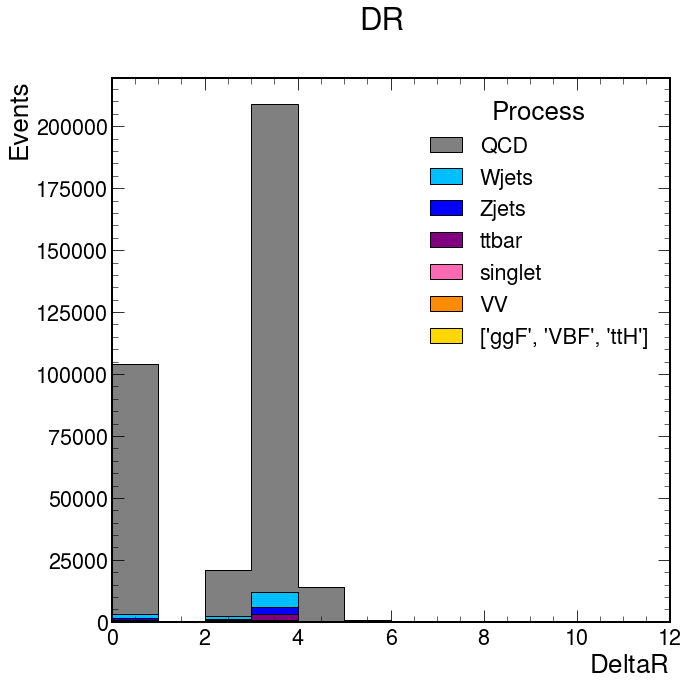

In [7]:
plot_mconly_vh(templates.sum('pt1','msd1','ddb1'),'DR','DR')

AttributeError: 'StepPatch' object has no property 'c'

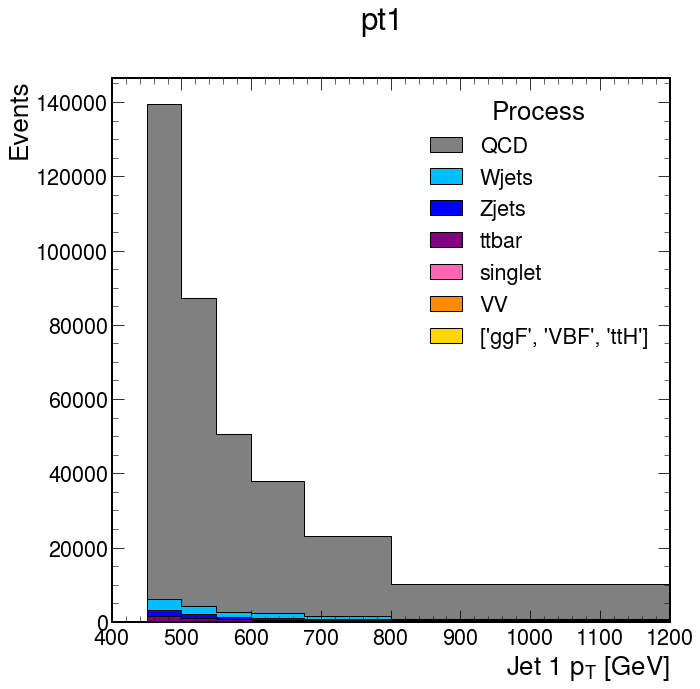

In [8]:
plot_mconly_vh(templates1.sum('ddb1','ddb2','msd1','msd2','pt2'),'pt1','pt1')

In [ ]:
plot_mconly_vh(templates1.sum('ddb1','ddb2','msd1','msd2','pt1'),'pt2','pt2')

In [ ]:
plot_mconly_vh(templates1.sum('ddb1','ddb2','msd2','pt1','pt2'),'msd1','msd1')

In [ ]:
plot_mconly_vh(templates1.sum('ddb1','ddb2','msd1','pt1','pt2'),'msd2','msd2')

In [17]:
mc = ['QCD','Wjets','Zjets','ttbar','singlet','VV','ggF','VBF','WH','ZH','ttH']
mc = ['Wjets']

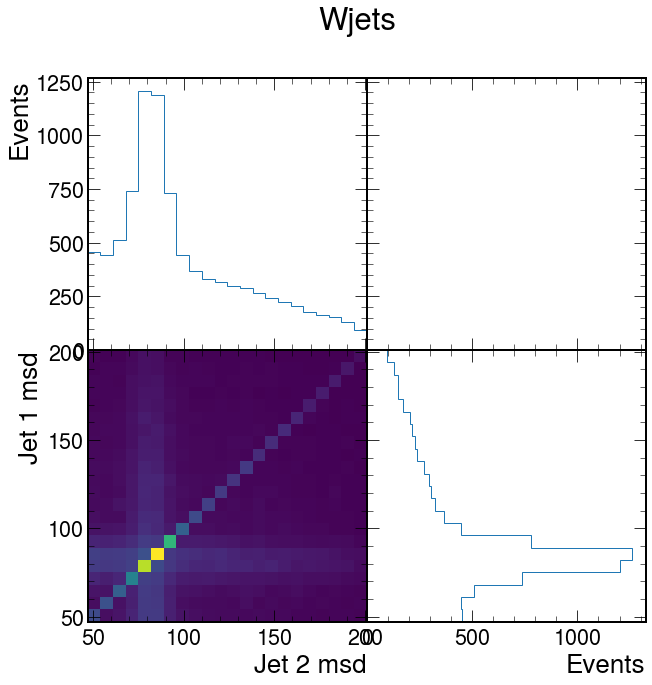

In [18]:
for p in mc:
    plot_2d(templates1.sum('pt1','pt2','ddb1','ddb2').integrate('process',p),'msd',year+'/'+p,p)

FileNotFoundError: [Errno 2] No such file or directory: '2017/QCD_ddb_2d.png'

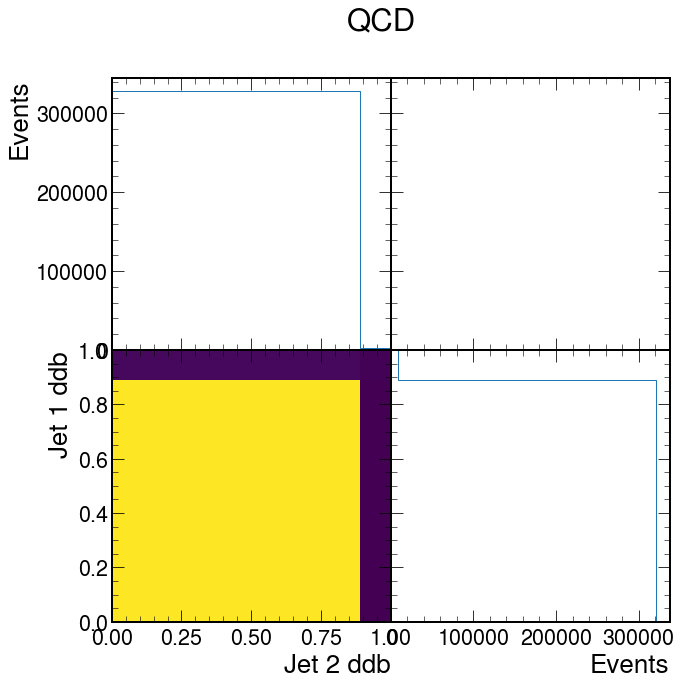

In [13]:
for p in mc:
    plot_2d(templates1.sum('pt1','pt2','msd1','msd2').integrate('process',p),'ddb',year+'/'+p,p)

In [ ]:
for p in mc:
    plot_2d(templates1.sum('msd1','msd2','ddb1','ddb2').integrate('process',p),'pt',year+'/'+p,p)

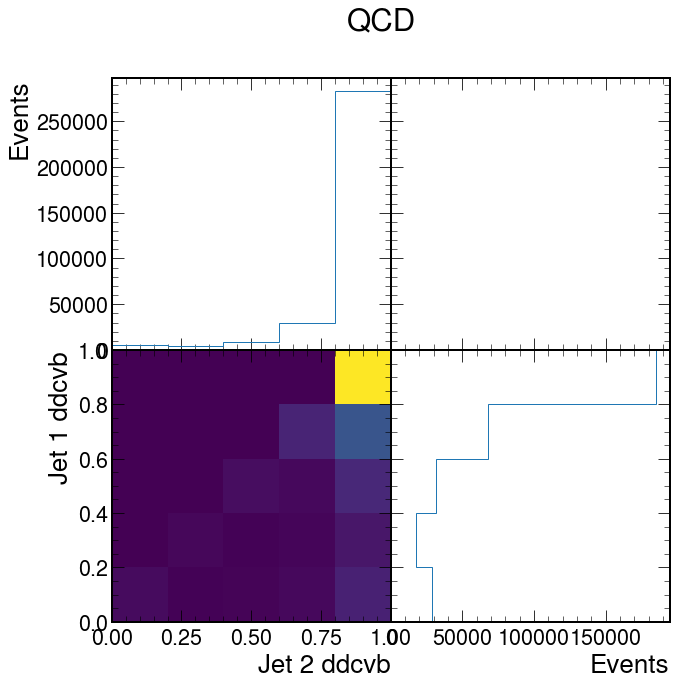

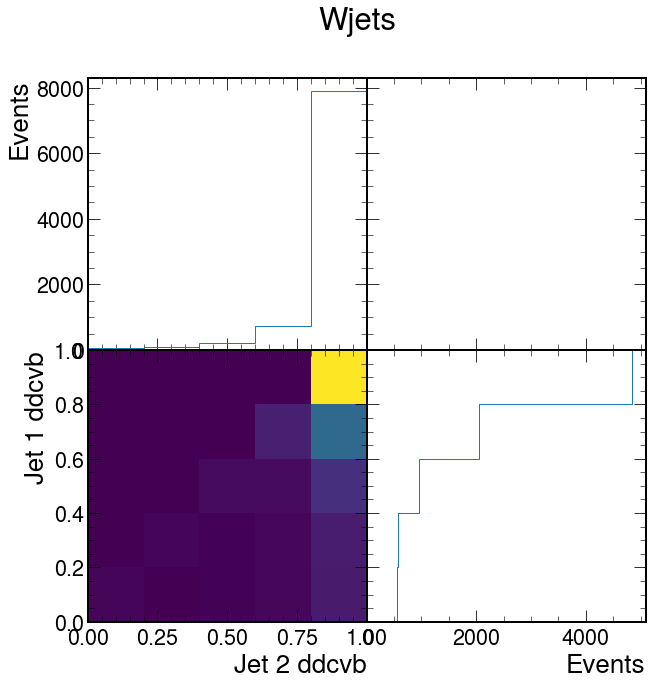

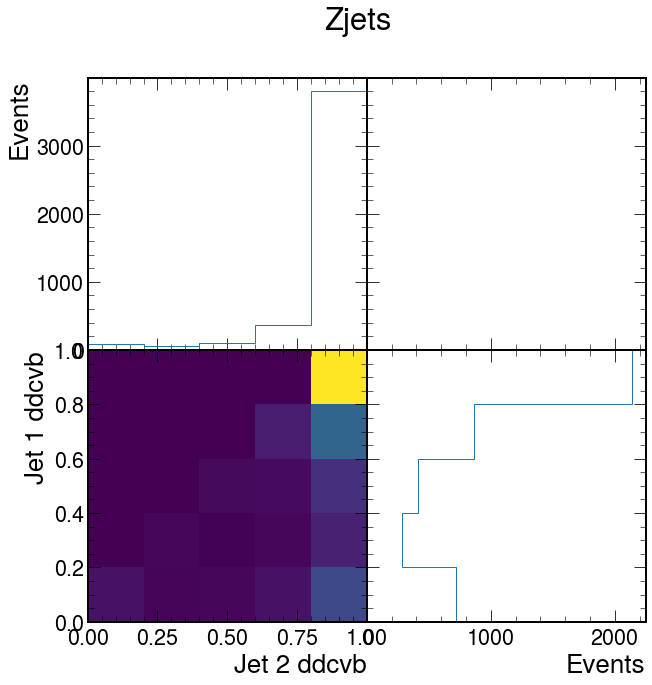

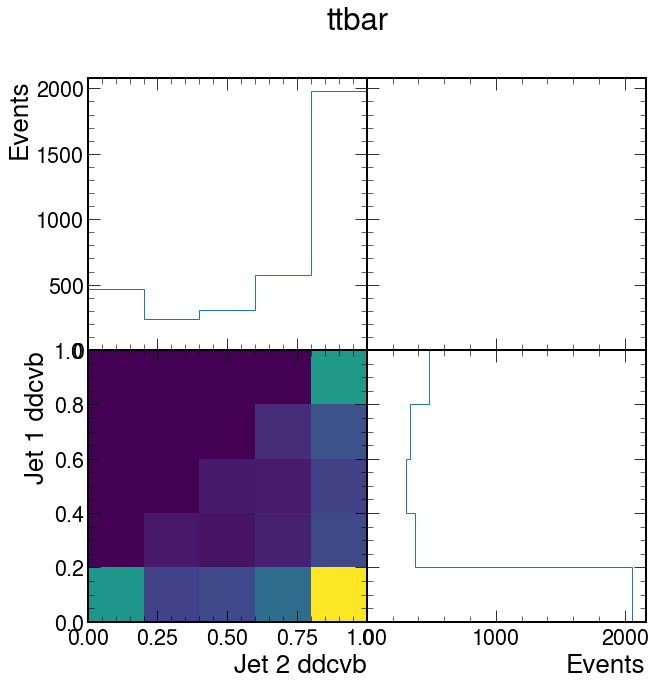

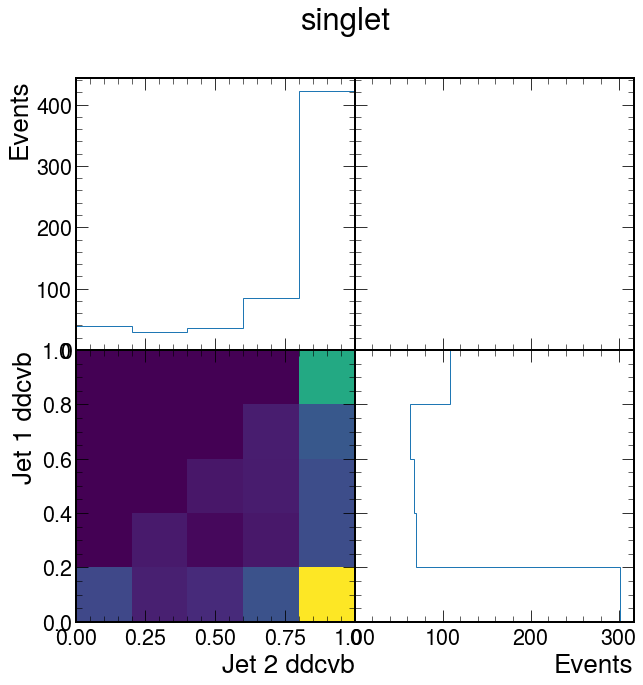

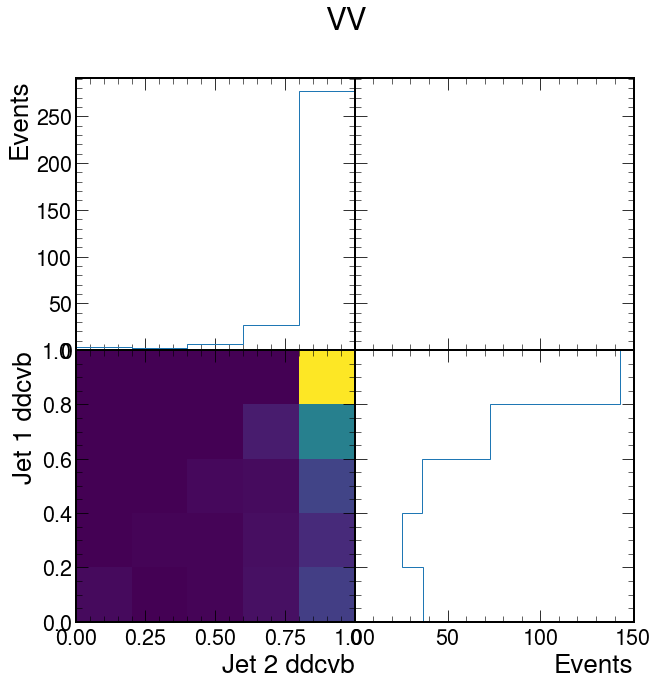

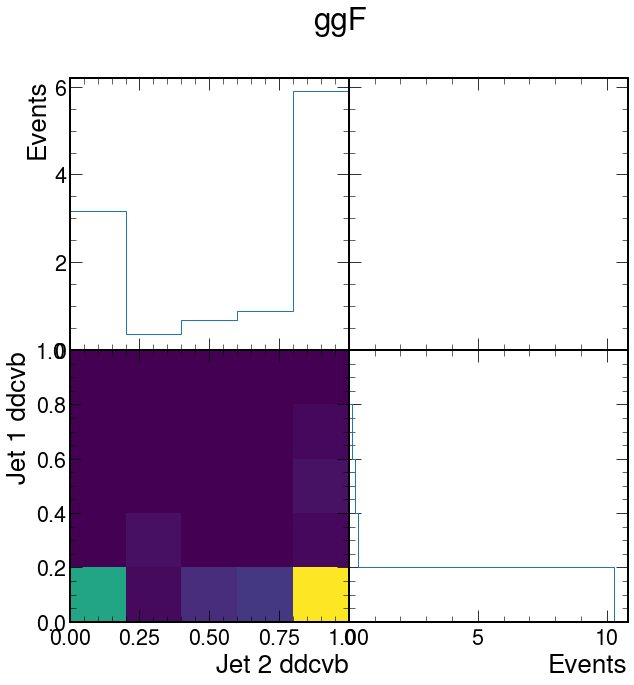

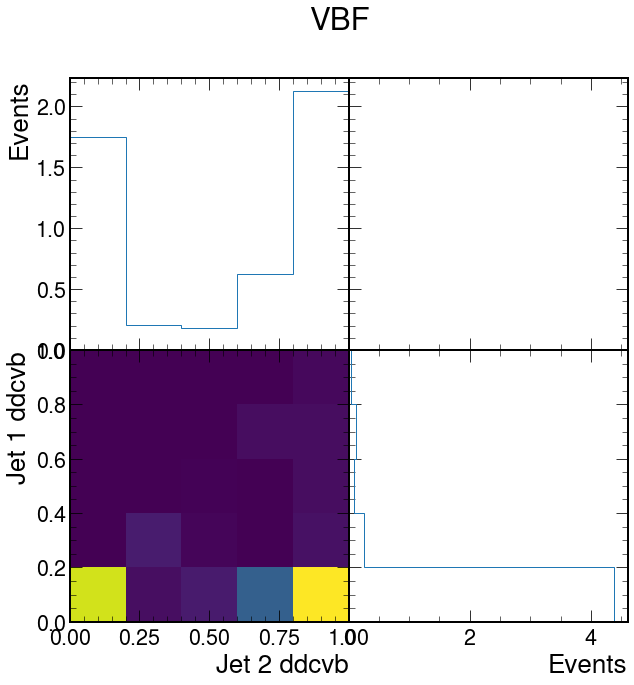

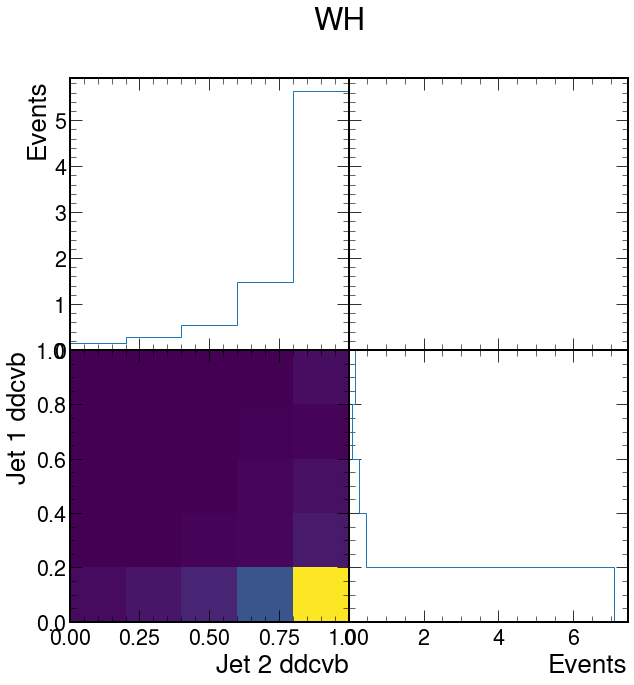

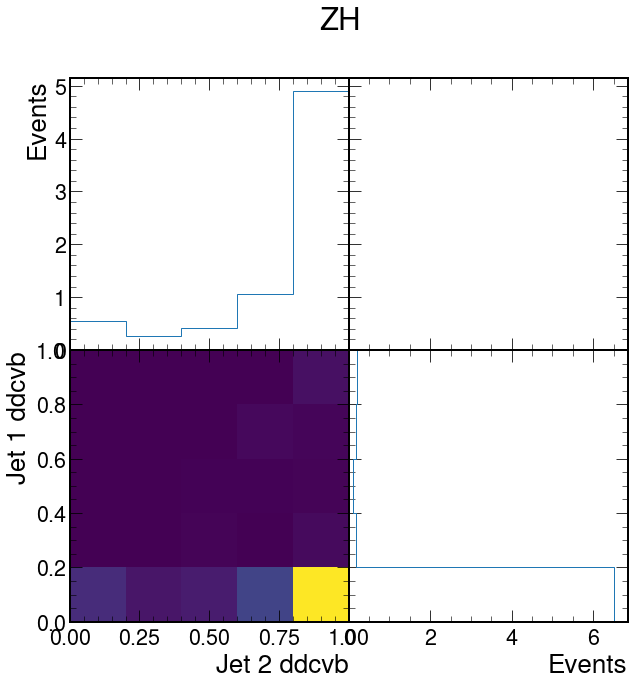

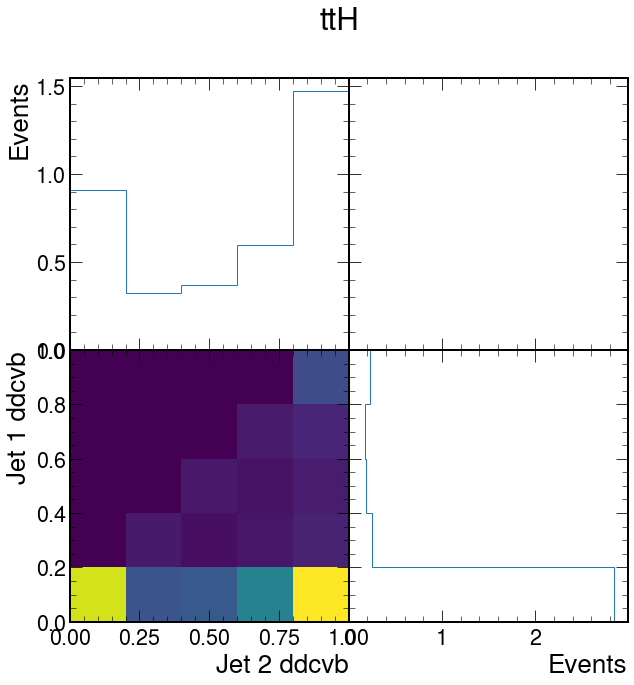

In [14]:
for p in mc:
    plot_2d(templates2.sum('msd1','msd2','ddb1','ddb2').integrate('process',p),'ddcvb',year+'/'+p,p)

In [ ]:
templates1.sum('pt1','pt2','ddb1','msd1','msd2').values()

In [ ]:
if year == '2017':

    # msd2 = H
    x = templates1.integrate('msd2',int_range=slice(mbb_min, mbb_max)).integrate('ddb2',int_range=slice(0.89,1))
    
    cuts3 = []
    sigs3 = []

    msd2_slices = [i*7+40 for i in range(1,23)]
    for msd2_min in msd2_slices:
        for msd2_max in msd2_slices:
            if msd2_max <= msd2_min:
                continue

            sliced = x.sum('pt1','pt2','ddb1').integrate('msd1',int_range=slice(msd2_min,msd2_max))
            s = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('VBF',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs3 += [significance(s,b)]
            cuts3 += [[msd2_min,msd2_max]]
        
    cuts3 = np.array(cuts3)
    print(max(sigs3))
    print(cuts3[np.argmax(sigs3)])

    msd_min_vh = cuts3[np.argmax(sigs3)][0]
    msd_max_vh = cuts3[np.argmax(sigs3)][1]

    plt.hist2d(cuts3[:,0], cuts3[:,1], density=False, weights=sigs3, bins=[21,21]);
    plt.xlabel('$msd_{min}$');
    plt.ylabel('$msd_{max}$');
    plt.colorbar()
    plt.savefig(year+'/vh_2d_msdminmax.png')

In [ ]:
if year == '2017':

    # msd1 = H
    x = templates1.integrate('msd1',int_range=slice(mbb_min, mbb_max)).integrate('ddb1',int_range=slice(0.89,1))
    
    cuts3 = []
    sigs3 = []

    msd2_slices = [i*7+40 for i in range(1,23)]
    for msd2_min in msd2_slices:
        for msd2_max in msd2_slices:
            if msd2_max <= msd2_min:
                continue

            sliced = x.sum('pt1','pt2','ddb2').integrate('msd2',int_range=slice(msd2_min,msd2_max))
            s = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('VBF',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs3 += [significance(s,b)]
            cuts3 += [[msd2_min,msd2_max]]
        
    cuts3 = np.array(cuts3)
    print(max(sigs3))
    print(cuts3[np.argmax(sigs3)])

    msd_min_vh = cuts3[np.argmax(sigs3)][0]
    msd_max_vh = cuts3[np.argmax(sigs3)][1]

    plt.hist2d(cuts3[:,0], cuts3[:,1], density=False, weights=sigs3, bins=[21,21]);
    plt.xlabel('$msd_{min}$');
    plt.ylabel('$msd_{max}$');
    plt.colorbar()
    plt.savefig(year+'/vh_2d_msdminmax.png')

In [ ]:
if year == '2017':

    x = templates2.sum('ddb2','ddb1').integrate('msd2',int_range=slice(68,103)).integrate('msd1',int_range=slice(mbb_min, mbb_max))#.integrate('ddb1',int_range=slice(0.89,1))
    
    cuts2 = []
    sigs2 = []

    ddcvb_slices = [0.0,0.2,0.4,0.6,0.8,1.0]
    for ddcvb1 in ddcvb_slices:
        for ddcvb2 in ddcvb_slices:

            sliced = x.integrate('ddcvb1',int_range=slice(0,ddcvb1)).integrate('ddcvb2',int_range=slice(ddcvb2,1))
            s = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('VBF',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            print(s,b,significance(s,b))
    
            sigs2 += [significance(s,b)]
            cuts2 += [[ddcvb1,ddcvb2]]
        
    cuts2 = np.array(cuts2)
    print(max(sigs2))
    print(cuts2[np.argmax(sigs2)])

    msd_min_vh = cuts2[np.argmax(sigs2)][0]
    msd_max_vh = cuts2[np.argmax(sigs2)][1]

    plt.hist2d(cuts2[:,0], cuts2[:,1], density=False, weights=sigs2, bins=[6,6]);
    plt.xlabel('DDCvB1');
    plt.ylabel('DDCvB2');
    plt.colorbar()
    plt.savefig(year+'/vh_2d_ddcvb.png')

In [ ]:
sr = x.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).values()
yield_plot(sr, 'vh-bkgopt')

In [ ]:
# significance
s = sr[('WH',)] + sr[('ZH',)]
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)]  + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('VBF',)] + sr[('ttH',)]

print(s,b)
print(significance(s,b))

sigma_2016 = 0.22765828968582566
sigma_2017 = 0.3187168794005945
sigma_2018 = 0.3295974584216346

# this only makes sense in the mass window of Higgs

In [ ]:
mhist = templates.integrate('ddb1',int_range=slice(0.89,1)).integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200))
plot_stack(mhist,'vh-msd1')

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.DataFrame(index=['$V$ jet $m_{sd}$','$V$ jet N2DDT','$V$ jet $p_T$','$H$ jet DeepDoubleB'],columns=['ggF','VBF','WH','ZH','ttH'])
df2 = pd.DataFrame(index=['$V$ jet $m_{sd}$','$V$ jet N2DDT','$V$ jet $p_T$','$H$ jet DeepDoubleB'],columns=['QCD','Wjets','Zjets','VV','ttbar','singlet'])

In [ ]:
# msd2 cut
tmp = templates.sum('msd1','pt2','n2ddt2','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).values()
cutname = '$V$ jet $m_{sd}$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [ ]:
# n2ddt2
tmp = templates.sum('msd1','pt2','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).values()
cutname = '$V$ jet N2DDT'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [ ]:
# pt2
tmp = templates.sum('msd1','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).values()
cutname = '$V$ jet $p_T$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [ ]:
# ddb1
tmp = templates.sum('msd1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).integrate('ddb1',int_range=slice(0.89,1)).values()
cutname = '$H$ jet DeepDoubleB'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [ ]:
print(df1)
df1 = df1.astype('int')
df1.to_latex(buf=year+'/cutflow-sig.tex')

In [ ]:
print(df2)
df2 = df2.astype('int')
df2.to_latex(buf=year+'/cutflow-bkg.tex')

In [ ]:
# Hard-coded -- combine results from all 3 years

VH = 0
tot_H = 0

#2016
VH += 2.4557 + 1.31369
tot_H += 0.258338 + 0.120521 + 2.4557 + 1.31369 + 0.177107

#2017
VH += 3.03186 + 1.75135
tot_H += 0.432971 + 0.181172 + 3.03186 + 1.75135 + 0.185175

#2018
VH += 3.97648 + 2.38145
tot_H += 0.319489 + 0.229331 + 3.97648 + 2.38145 + 0.272887

print(VH/tot_H)

In [ ]:
np.sqrt(sigma_2016**2 + sigma_2017**2 + sigma_2018**2)